In [ ]:
%%writefile app.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from itertools import combinations
from plotly.subplots import make_subplots
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')


Writing app.py


In [ ]:
df = pd.read_csv('/content/Mall_Customers.csv')
print("Dataset Shape:", df.shape)
display(df.head())

Dataset Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
print( df.isnull().sum())
print( df.dtypes)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


In [ ]:
numeric_df = df.select_dtypes(include=['number'])

# Create a correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap using Plotly
fig = px.imshow(
    corr_matrix,
    text_auto=True,            # Show numbers inside squares
    color_continuous_scale='RdBu_r',  # Color theme (you can change)
    title='Correlation Heatmap'
)

fig.show()

In [ ]:
features = df.select_dtypes(include=[np.number]).dropna(axis=1)
print(features.columns.tolist())

['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [ ]:
#NLP - Text Feature Extraction
if 'feedback' in df.columns:
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    text_embeddings = model.encode(df['feedback'].tolist())
    print("Text Embedding Shape:", np.array(text_embeddings).shape)
else:
    print("⚠️ No 'feedback' column found. Using dummy embeddings.")
    text_embeddings = np.zeros((df.shape[0], 300))

⚠️ No 'feedback' column found. Using dummy embeddings.


In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
 #Combine Numerical + Text Features
combined_features = np.hstack([scaled_features, text_embeddings])

In [ ]:
#Finding Optimal K (KMeans - Elbow + Silhouette)
wcss = []
silhouette_scores = []
K = range(2, 11)

In [ ]:
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(combined_features)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(combined_features, kmeans.labels_))


In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Elbow Method', 'Silhouette Score'))

# Plot Elbow Method (WCSS)
fig.add_trace(
    go.Scatter(x=list(K), y=wcss, mode='lines+markers', marker=dict(color='blue'), name='WCSS'),
    row=1, col=1
)

# Plot Silhouette Score
fig.add_trace(
    go.Scatter(x=list(K), y=silhouette_scores, mode='lines+markers', marker=dict(color='green'), name='Silhouette Score'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text='K-Means Clustering Evaluation Metrics',
    width=1000,
    height=400,
    showlegend=False
)

# Update x and y labels
fig.update_xaxes(title_text="K (Number of Clusters)", row=1, col=1)
fig.update_yaxes(title_text="WCSS", row=1, col=1)
fig.update_xaxes(title_text="K (Number of Clusters)", row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

# Show the plot
fig.show()


In [ ]:
optimal_k = 4  # Update based on plots
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(combined_features)
df['KMeans_Cluster'] = cluster_labels

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(combined_features)
df['DBSCAN_Cluster'] = dbscan_labels

In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(combined_features)

In [ ]:
print("\nPCA Explained Variance Ratio:")
for idx, var in enumerate(pca.explained_variance_ratio_):
    print(f"Component {idx+1}: {var*100:.2f}%")


PCA Explained Variance Ratio:
Component 1: 49.48%
Component 2: 33.14%


In [ ]:
# Cumulative Variance Plot
components = list(range(1, len(pca.explained_variance_ratio_) + 1))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Create the figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=components,
        y=cumulative_variance,
        mode='lines+markers',
        line=dict(dash='dash', color='royalblue'),
        marker=dict(size=8),
        name='Cumulative Variance'
    )
)

# Update layout
fig.update_layout(
    title='Cumulative Explained Variance by PCA Components',
    xaxis_title='Number of PCA Components',
    yaxis_title='Cumulative Variance Explained',
    width=700,
    height=500,
    template='plotly_white'
)

# Show the plot
fig.show()

In [ ]:
#Visualize Clusters (KMeans)
pca_df = pd.DataFrame({
    'PCA1': pca_components[:, 0],
    'PCA2': pca_components[:, 1],
    'Cluster': cluster_labels
})

# Plot using Plotly Express
fig = px.scatter(
    pca_df,
    x='PCA1',
    y='PCA2',
    color='Cluster',
    title='Customer Segmentation (KMeans + PCA)',
    color_continuous_scale='viridis',
    width=800,
    height=600
)

# Update marker size
fig.update_traces(marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey')))

# Update layout
fig.update_layout(
    legend_title_text='Cluster',
    template='plotly_white'
)

# Show plot
fig.show()

In [ ]:
# Group by cluster and take mean only for numeric columns
profile = df.groupby('KMeans_Cluster').mean(numeric_only=True)

print("\nCluster Profiling:\n", profile)



Cluster Profiling:
                 CustomerID        Age  Annual Income (k$)  \
KMeans_Cluster                                              
0                69.350000  54.766667           47.933333   
1               160.048780  32.731707           85.634146   
2                50.610169  25.949153           38.779661   
3               159.775000  40.275000           85.925000   

                Spending Score (1-100)  DBSCAN_Cluster  
KMeans_Cluster                                          
0                            41.783333        1.750000  
1                            80.902439        3.439024  
2                            58.067797        0.254237  
3                            19.750000       -1.000000  


In [ ]:
cluster_counts = df['KMeans_Cluster'].value_counts().sort_index()

In [ ]:
# Create a DataFrame for cluster counts
cluster_counts_df = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Count': cluster_counts.values
})

# Plot using Plotly Express
fig = px.bar(
    cluster_counts_df,
    x='Cluster',
    y='Count',
    color='Cluster',
    title='Number of Customers per Cluster',
    color_continuous_scale='viridis',
    width=800,
    height=500
)

# Update layout
fig.update_layout(
    xaxis_title='Cluster',
    yaxis_title='Number of Customers',
    template='plotly_white'
)

# Show plot
fig.show()

In [ ]:
print(cluster_counts_df.columns)

Index(['Cluster', 'Count'], dtype='object')


In [ ]:
print(cluster_counts_df.head())

   Cluster  Count
0        0     60
1        1     41
2        2     59
3        3     40


In [ ]:
dz = cluster_counts_df['Count']  # Replace 'Cluster_Count' with the actual column name

In [ ]:
fig = px.scatter_3d(cluster_counts_df, x='Cluster', y='Count', z=[0] * len(cluster_counts_df), color='Count') #optional

# Update layout for better appearance
fig.update_layout(
    title='3D Scatter Plot of Cluster Counts',
    scene=dict(
        xaxis_title='Cluster',
        yaxis_title='Count',
        zaxis_title='Z'
    )
)

# Show the plot
fig.show()

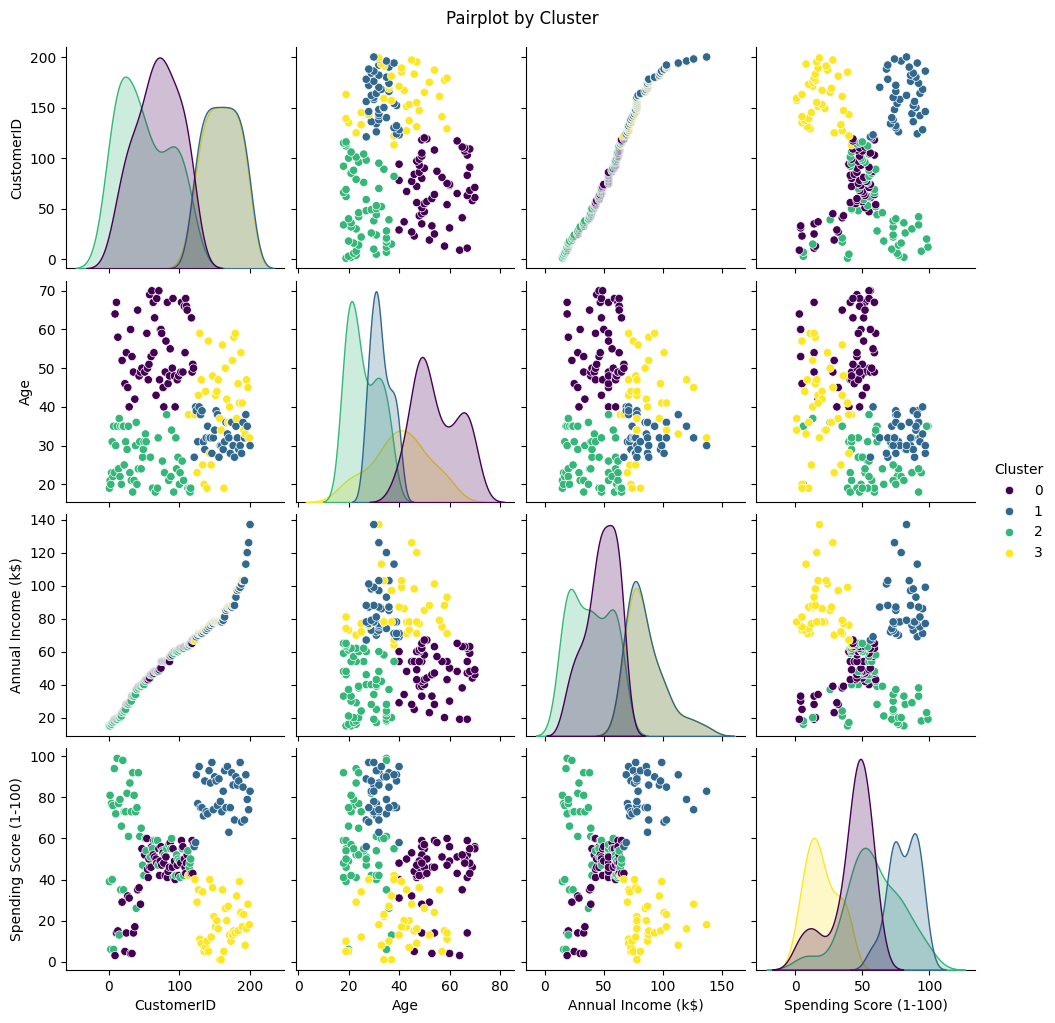

In [ ]:
pairplot_data = features.copy()
pairplot_data['Cluster'] = cluster_labels
sns.pairplot(pairplot_data, hue='Cluster', palette='viridis')
plt.suptitle('Pairplot by Cluster', y=1.02)
plt.show()

In [ ]:
# 15. Sentiment Analysis on Feedback (if available)
if 'feedback' in df.columns:
    sentiment_pipeline = pipeline('sentiment-analysis')
    df['Sentiment'] = df['feedback'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
    print("\nSentiment Analysis Samples:\n")
    display(df[['feedback', 'Sentiment']].head())


In [ ]:
# 16. Save Segmented Dataset
df.to_csv('/content/sample_data.csv', index=False)
print("\n✅ Segmented Data Saved as 'customers_segmented.csv'")


✅ Segmented Data Saved as 'customers_segmented.csv'
